In [1]:
import pandas as pd

# Load datasets
plsc_df = pd.read_csv(r"B:\Final Network Science Project\Data\PLSCI\PLSCI.csv")  # Port Linear Shipping Connectivity Index
lsbci_df = pd.read_csv(r"B:\Final Network Science Project\Data\LSBCI\LSBCI.csv") # Linear Shipping Bilateral Connectivity Index

# Step 1: Cross join PLSCI dataset
plsc_df['key'] = 1
cross_joined = plsc_df.merge(plsc_df, on='key', suffixes=('_A', '_B')).drop('key', axis=1)

# Step 2: Extract countries
cross_joined['country_A'] = cross_joined['Port_Label_A'].str.split(', ').str[0]
cross_joined['country_B'] = cross_joined['Port_Label_B'].str.split(', ').str[0]

# Step 3: Merge LSBCI data
merged = cross_joined.merge(lsbci_df, left_on=['country_A', 'country_B'], right_on=['Economy_Label', 'Partner_Label'], how='left')
merged.rename(columns={'Index_Value': 'LSBCI_AB'}, inplace=True)

# Step 4: Apply formula
merged['PLSBCI'] = ((merged['Index_Value_A'] * merged['LSBCI_AB']) + 
                    (merged['Index_Value_B'] * merged['LSBCI_AB'])) / 2

# Step 5: Select required columns
result = merged[['Port_Label_A', 'Port_Label_B', 'PLSBCI']]
result.to_csv(r"PLSBCI_Output.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv(r'B:\Final Network Science Project\PLSBCI_Output.csv')

# Sort the dataframe by Index in descending order
df_sorted = df.sort_values('PLSBCI', ascending=False)

# Get the 25,496th highest value (which is the 12,748th pair) 
threshold = df_sorted.iloc[25496]['PLSBCI']

# Modify the original Index column
df['PLSBCI'] = np.where(df['PLSBCI'] >= threshold, df['PLSBCI'], 0)

# Save the modified dataframe to a new CSV file
df.to_csv('B:\Final Network Science Project\Data\Mr_PLSBCI.csv', index=False)


<>:17: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shivp\AppData\Local\Temp\ipykernel_15276\2079549135.py:17: SyntaxWarning: invalid escape sequence '\F'
  df.to_csv('B:\Final Network Science Project\Data\Mr_PLSBCI.csv', index=False)


In [12]:
import xml.etree.ElementTree as ET

# Function to determine the region based on latitude and longitude
def determine_region(lat, lon):
    lat = float(lat)
    lon = float(lon)
    
    # Special bifurcation for China, India, and Singapore
    if 18 <= lat <= 55 and 73 <= lon <= 135:  # Approximate range for China
        return "China"
    elif 6 <= lat <= 35 and 68 <= lon <= 97:  # Approximate range for India
        return "India"
    elif 1 <= lat <= 2 and 103 <= lon <= 104:  # Approximate range for Singapore
        return "Singapore"
    
    # General regions
    if -50 <= lat <= 0 and 110 <= lon <= 180:
        return "Australasia & Oceania"
    elif -10 <= lat <= 60 and 90 <= lon <= 180:
        return "East & South-East Asia"
    elif 30 <= lat <= 70 and -30 <= lon <= 60:
        return "Europe & Mediterranean"
    elif 0 <= lat <= 30 and 40 <= lon <= 90:
        return "Gulf & South Asia"
    elif -60 <= lat <= 30 and -120 <= lon <= -30:
        return "Latin America & the Caribbean"
    elif 20 <= lat <= 80 and -170 <= lon <= -50:
        return "North America"
    elif -35 <= lat <= 15 and -20 <= lon <= 55:
        return "Sub-Saharan Africa"
    else:
        return "Unknown"

# Parse the GraphML file
graphml_file = r"B:\Final Network Science Project\Data\grpah file\FinalPortNetworkGrpah.graphml"
tree = ET.parse(graphml_file)
root = tree.getroot()

# Define namespace
ns = {'': 'http://graphml.graphdrawing.org/xmlns'}
ET.register_namespace('', ns[''])

# Add a new key for the region
ET.SubElement(root, 'key', {
    'id': 'region',
    'for': 'node',
    'attr.name': 'region',
    'attr.type': 'string'
})

# Iterate over nodes and assign regions
for node in root.findall('.//{http://graphml.graphdrawing.org/xmlns}node'):
    latitude = None
    longitude = None

    # Find latitude and longitude for the node
    for data in node.findall('./{http://graphml.graphdrawing.org/xmlns}data'):
        if data.get('key') == 'latitude':
            latitude = data.text
        elif data.get('key') == 'longitude':
            longitude = data.text

    # Assign region if latitude and longitude are found
    if latitude is not None and longitude is not None:
        region = determine_region(latitude, longitude)
        ET.SubElement(node, '{http://graphml.graphdrawing.org/xmlns}data', {'key': 'region'}).text = region

# Save the modified GraphML file
output_file = r"B:\Final Network Science Project\Data\grpah file\portnetwork.graphml"
tree.write(output_file, encoding='utf-8', xml_declaration=True)

print(f"Modified GraphML file with regions saved at: {output_file}")




Modified GraphML file with regions saved at: B:\Final Network Science Project\Data\grpah file\portnetwork.graphml


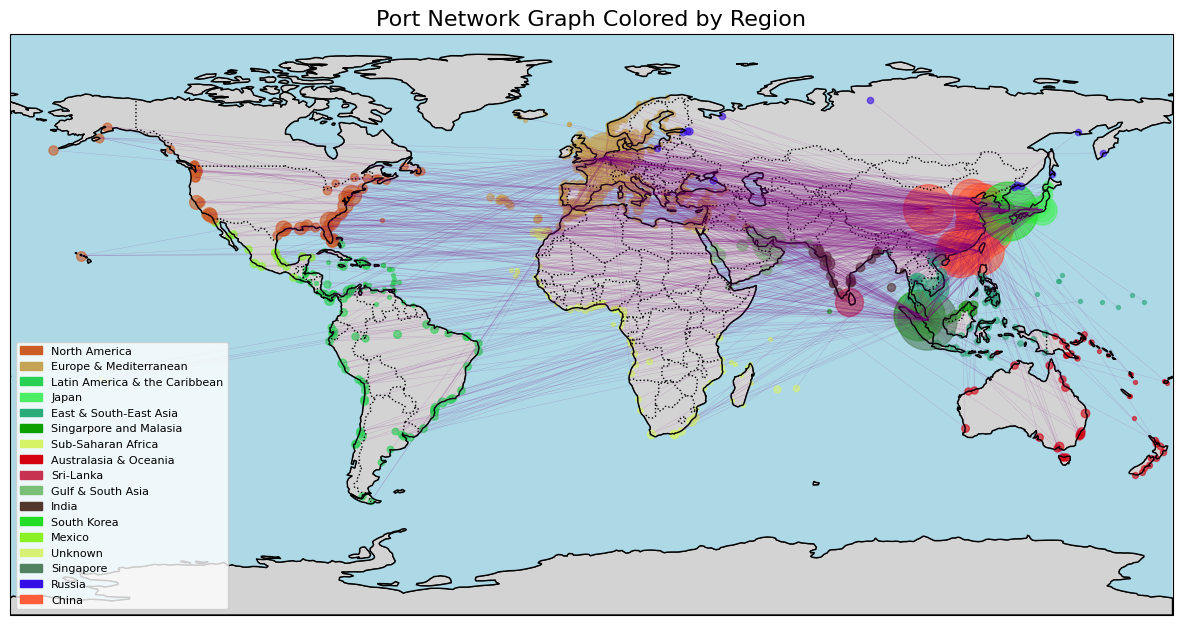

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
import matplotlib.patches as mpatches

# Load the GraphML file
graphml_file = r"B:\Final Network Science Project\Data\grpah file\Shipping_Network.graphml"
G = nx.read_graphml(graphml_file)

# Extract node coordinates, degree, and region information
node_positions = {}
node_degrees = {}
node_regions = {}

for node, data in G.nodes(data=True):
    latitude = data.get('latitude')
    longitude = data.get('longitude')
    region = data.get('region', 'Unknown')  # Default to 'Unknown' if region is missing
    
    if latitude and longitude:
        node_positions[node] = (float(longitude), float(latitude))  # Longitude first for mapping
    node_degrees[node] = G.degree(node)
    node_regions[node] = region

# Assign a unique color to each region
unique_regions = set(node_regions.values())
region_colors = {region: (random.random(), random.random(), random.random()) for region in unique_regions}

# Reduce the number of edges by filtering only the top connections
filtered_edges = [edge for edge in G.edges() if random.random() < 0.1]  # Keep only 10% of edges

# Plot the graph on a world map using Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw nodes with smaller size and transparency
for node, (lon, lat) in node_positions.items():
    degree = node_degrees[node]
    region = node_regions[node]
    ax.scatter(
        lon, lat,
        s=max(degree * 2, 5),  # Smaller node size, minimum size set to 5
        color=region_colors[region],
        alpha=0.6,  # Adjusted transparency for nodes
        transform=ccrs.PlateCarree()
    )

# Draw edges with more visibility and transparency
for source, target in filtered_edges:
    if source in node_positions and target in node_positions:
        lon1, lat1 = node_positions[source]
        lon2, lat2 = node_positions[target]
        ax.plot(
            [lon1, lon2], [lat1, lat2],
            color='purple',  # Keep edges in purple
            linewidth=0.3,  # Slightly thinner edges
            alpha=0.2,  # Increased transparency for edges
            transform=ccrs.PlateCarree()
        )

# Add title and legend
plt.title("Port Network Graph Colored by Region", fontsize=16)

# Create legend
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
plt.legend(handles=legend_patches, loc="lower left", fontsize=8)

plt.show()
